In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
# import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2022-10-11 20:50:34.754513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 20:50:34.971095: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 20:50:35.750799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 20:50:35.750889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

Num GPUs Available:  0


2022-10-11 20:50:37.260097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: /usr/local/cuda-11.0/targets/x86_64-linux/lib/libcublas.so.11: symbol runGemmApi version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference; LD_LIBRARY_PATH: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-11 20:50:37.265767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-11 20:50:37.265899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ho

In [3]:
num_class = 10
max_num_target = 3
print('num_class:', num_class)
print('num_target:', max_num_target)

num_class: 10
num_target: 3


## Data loading functions 

In [4]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [5]:
def load_hdf5(filename):
    return h5py.File(filename, "r")

## Callbacks

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=20, restore_best_weights=True
)

In [7]:
def checkpoint_filepath(filename):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filename,
        save_weights_only = False,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True)
    return checkpoint_callback

## Data generators

In [8]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [9]:
def data_generator_pred(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

## Single act network

In [10]:
def nn_singleact(input_shapex):
    inputlayer1 = Input(shape = input_shapex)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(240, activation='relu')(x)
    out1 = Dense(num_class,activation='softmax')(x)
#     x = Reshape(target_shape = (max_num_target, 240//max_num_target))(x)
#     x = Dropout(0.5)(x)
#     out1 = TimeDistributed(Dense(num_class,activation='sigmoid'))(x)
#     x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#     out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
    model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    return model 

In [11]:
# def cnn(input_shapex):
#     inputlayer1 = Input(shape = input_shapex)
#     x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
    
#     return x 

In [12]:
# def tpn(base_layers, max_num_target):
#     x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(base_layers)
    
#     # classification layers to predict if there is target or not
#     x_class = Conv2D(max_num_target, kernel_size=(1, 1), activation='sigmoid')(x)
    
#     return [x_class, base_layers]

In [44]:
# data

[x_train, train_vids, train_skels, y_train,
 x_test, test_vids, test_skels, y_test] = load_pkl('datasets/WLASL_10_vid_skel_mDsim.pkl')
x_train = x_train.astype(np.float32) # .astype(np.uint8)
x_test = x_test.astype(np.float32) # .astype(np.uint8) # .astype(np.float64)

print('Data shapes:')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Data shapes:
(224, 128, 128, 3)
(224, 10)
(56, 128, 128, 3)
(56, 10)


In [45]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print('Input shape: ', input_shape)

Input shape:  (128, 128, 3)


In [50]:
batch_size = 64
model_name = 'models/wlasl_keras'
checkpoint_callback = checkpoint_filepath(model_name)
nn = nn_singleact(input_shape)

train_dataset = data_generator(x_train, y_train, batch_size)
validation_dataset = data_generator(x_test, y_test, batch_size)

/home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


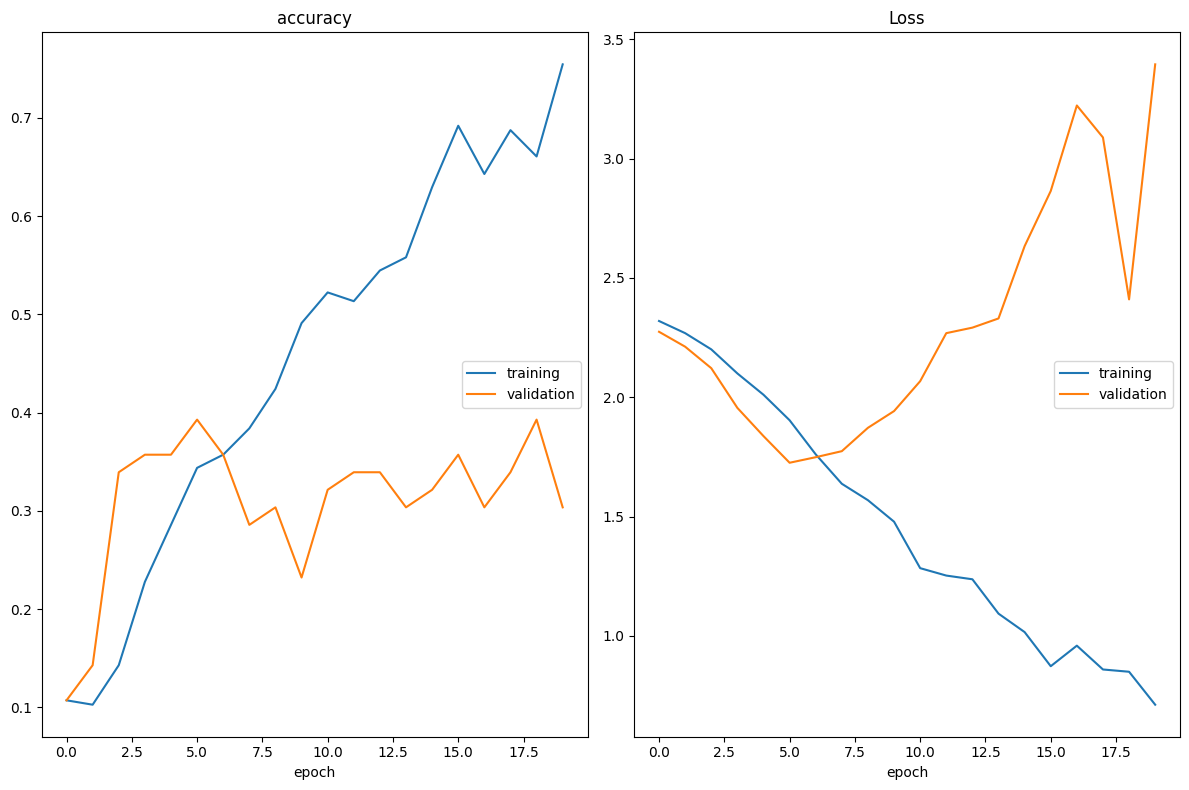

accuracy
	training         	 (min:    0.103, max:    0.754, cur:    0.754)
	validation       	 (min:    0.107, max:    0.393, cur:    0.304)
Loss
	training         	 (min:    0.711, max:    2.320, cur:    0.711)
	validation       	 (min:    1.725, max:    3.395, cur:    3.395)
4/4 [==============================] - 2s 471ms/step - loss: 0.7113 - accuracy: 0.7545 - val_loss: 3.3953 - val_accuracy: 0.3036


In [51]:
# history = nn.fit(
#     np.array(x_train), np.array(y_train),
#     validation_data = [np.array(x_test), np.array(y_test)],
#     batch_size = batch_size,
#     epochs=200,
#     shuffle=False,
#     callbacks=[early_stopping, PlotLossesKerasTF(), checkpoint_callback],
#     verbose = 1
# )

history = nn.fit(
    train_dataset,
    validation_data=validation_dataset,
#     batch_size = 1,
    epochs=20,
    shuffle = False,
    steps_per_epoch = math.ceil(len(y_train) / batch_size), validation_steps = math.ceil(len(y_test) / batch_size),
    callbacks=[PlotLossesKerasTF(), checkpoint_callback],
    verbose = 1
)

In [ ]:
[print(i.shape, i.dtype) for i in nn.inputs]

In [ ]:
[print(o.shape, o.dtype) for o in nn.outputs]

In [28]:
[print(l.name, l.input_shape, l.dtype) for l in nn.layers]

input_3 [(None, 128, 128, 3)] float32
conv2d_8 (None, 128, 128, 3) float32
max_pooling2d_8 (None, 128, 128, 32) float32
conv2d_9 (None, 64, 64, 32) float32
max_pooling2d_9 (None, 64, 64, 64) float32
conv2d_10 (None, 32, 32, 64) float32
max_pooling2d_10 (None, 32, 32, 128) float32
conv2d_11 (None, 16, 16, 128) float32
max_pooling2d_11 (None, 16, 16, 128) float32
flatten_2 (None, 8, 8, 128) float32
dense_6 (None, 8192) float32
dense_7 (None, 120) float32
dense_8 (None, 240) float32


[None, None, None, None, None, None, None, None, None, None, None, None, None]